<a href="https://colab.research.google.com/github/sonalisanjeevprabu18/Large-Language-Models/blob/main/BERT_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔒 FROZEN BERT
  Epoch 1 | Loss: 1.4026 | Acc: 0.2500
  Epoch 2 | Loss: 1.3918 | Acc: 0.2400
  Epoch 3 | Loss: 1.3880 | Acc: 0.2550


/usr/local/lib/python3.12/dist-packages/huggingface_hub/file_download.py:949: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



🔓 FULL FINE-TUNING
  Epoch 1 | Loss: 0.9138 | Acc: 0.8550
  Epoch 2 | Loss: 0.3433 | Acc: 0.8500
  Epoch 3 | Loss: 0.1908 | Acc: 0.8400


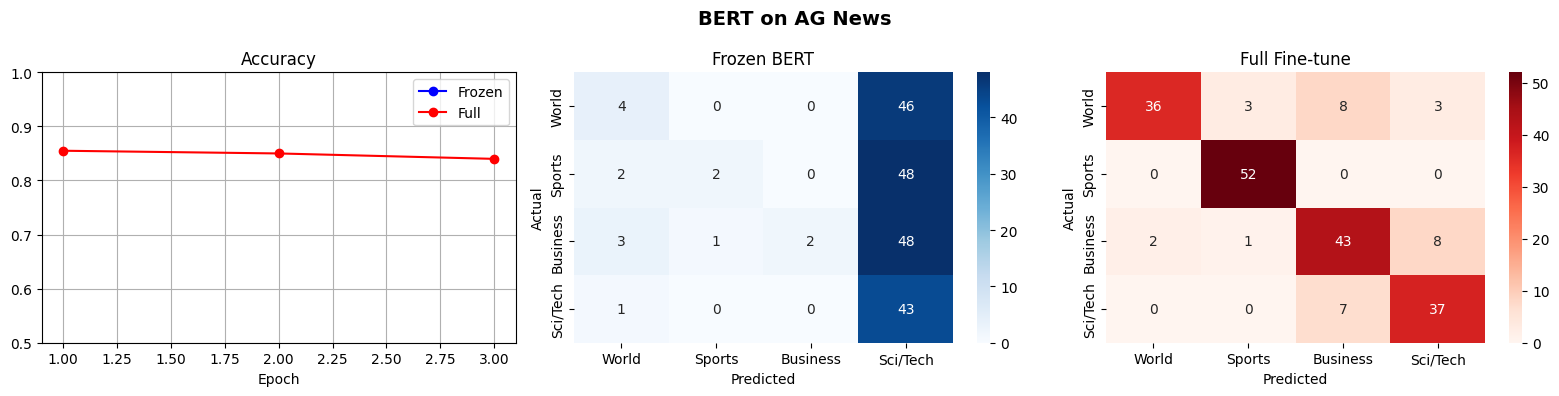


  Frozen BERT Final Acc : 0.2550
  Full Fine-tune Acc    : 0.8400


In [13]:
# ── Step 1: Install ──────────────────────────────────────────────
!pip install transformers==4.40.0 datasets scikit-learn -q

# ── Step 2: Imports ──────────────────────────────────────────────
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
from datasets import load_dataset
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.optim import AdamW

# ── Step 3: Load Data ────────────────────────────────────────────
dataset    = load_dataset("ag_news")
train_data = dataset["train"].shuffle(seed=42).select(range(1000))
test_data  = dataset["test"].shuffle(seed=42).select(range(200))

tokenizer  = BertTokenizer.from_pretrained("bert-base-uncased")

# ── Step 4: Dataset Class ────────────────────────────────────────
class NewsDataset(Dataset):
    def __init__(self, data):
        self.texts  = data["text"]
        self.labels = data["label"]

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = tokenizer(self.texts[idx], padding="max_length",
                        truncation=True, max_length=128, return_tensors="pt")
        return {
            "input_ids":      enc["input_ids"].squeeze(),
            "attention_mask": enc["attention_mask"].squeeze(),
            "labels":         torch.tensor(self.labels[idx])
        }

train_loader = DataLoader(NewsDataset(train_data), batch_size=16, shuffle=True)
test_loader  = DataLoader(NewsDataset(test_data),  batch_size=16)

# ── Step 5: Train & Evaluate ─────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def run(freeze=True):
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased", num_labels=4).to(device)

    if freeze:
        for name, param in model.named_parameters():
            if "classifier" not in name:
                param.requires_grad = False
        print("\n🔒 FROZEN BERT")
    else:
        print("\n🔓 FULL FINE-TUNING")

    optimizer = AdamW(filter(lambda p: p.requires_grad,
                             model.parameters()), lr=2e-5)
    losses, accs = [], []

    for epoch in range(3):
        # Train
        model.train()
        total_loss = 0
        for batch in train_loader:
            ids  = batch["input_ids"].to(device)
            mask = batch["attention_mask"].to(device)
            labs = batch["labels"].to(device)
            optimizer.zero_grad()
            loss = model(input_ids=ids, attention_mask=mask, labels=labs).loss
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Evaluate
        model.eval()
        preds, true = [], []
        with torch.no_grad():
            for batch in test_loader:
                ids  = batch["input_ids"].to(device)
                mask = batch["attention_mask"].to(device)
                out  = model(input_ids=ids, attention_mask=mask)
                preds += torch.argmax(out.logits, dim=1).cpu().tolist()
                true  += batch["labels"].tolist()

        acc = accuracy_score(true, preds)
        avg_loss = total_loss / len(train_loader)
        losses.append(avg_loss)
        accs.append(acc)
        print(f"  Epoch {epoch+1} | Loss: {avg_loss:.4f} | Acc: {acc:.4f}")

    return losses, accs, preds, true

# ── Step 6: Run Both ─────────────────────────────────────────────
loss_f, acc_f, preds_f, true_f = run(freeze=True)
loss_u, acc_u, preds_u, true_u = run(freeze=False)

# ── Step 7: Visualize ────────────────────────────────────────────
classes = ["World", "Sports", "Business", "Sci/Tech"]
epochs  = [1, 2, 3]

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
fig.suptitle("BERT on AG News", fontsize=14, fontweight="bold")

# Accuracy curve
axes[0].plot(epochs, acc_f, 'b-o', label='Frozen')
axes[0].plot(epochs, acc_u, 'r-o', label='Full')
axes[0].set_title("Accuracy"); axes[0].set_xlabel("Epoch")
axes[0].legend(); axes[0].grid(True); axes[0].set_ylim(0.5, 1.0)

# Confusion Matrix - Frozen
sns.heatmap(confusion_matrix(true_f, preds_f), annot=True, fmt='d',
            cmap='Blues', xticklabels=classes, yticklabels=classes, ax=axes[1])
axes[1].set_title("Frozen BERT")
axes[1].set_xlabel("Predicted"); axes[1].set_ylabel("Actual")

# Confusion Matrix - Full
sns.heatmap(confusion_matrix(true_u, preds_u), annot=True, fmt='d',
            cmap='Reds', xticklabels=classes, yticklabels=classes, ax=axes[2])
axes[2].set_title("Full Fine-tune")
axes[2].set_xlabel("Predicted"); axes[2].set_ylabel("Actual")

plt.tight_layout()
plt.show()

# ── Step 8: Final Summary ────────────────────────────────────────
print("\n" + "="*35)
print(f"  Frozen BERT Final Acc : {acc_f[-1]:.4f}")
print(f"  Full Fine-tune Acc    : {acc_u[-1]:.4f}")
print("="*35)